---
# Import standard Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
import re
import statsmodels.api as sm
from scipy import stats
from scipy.special import inv_boxcox

from collections import defaultdict
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

---
# Import Dataset

In [2]:
train_data = pd.read_csv('TrainingData.csv', encoding = "ISO-8859-1", dtype={
    "property_id": str,
    "transaction_date": str,
    "sale_price": float,
    "deed_type": str,
    "address_number": str,
    "pre_direction_code": str,
    "street_name": str,
    "street_type_code": str,
    "unit_no": str,
    "location_zip_code": int,
    "city_name": str,
    "section": int,
    "township": int,
    "range": int,
    "quarter": str,
    "land_economic_area_code": str,
    "vacant_flag": str,
    "total_net_acres": float,
    "tax_district_no": int,
    "neighborhood_code": str,
    "neighborhood_extension": str,
    "grantor": str,
    "grantee": str,
    "style": str,
    "built_as_code": int,
    "built_as": str,
    "quality_code": str,
    "property_type_code": str,
    "improvement_sf": int,
    "completion_percent": float,
    "unit_type": str,
    "no_of_fireplace": int,
    "total_garage_sf": int,
    "walkout_basement_flag": str,
    "total_porch_sf": float,
    "total_finished_basement_sf": int,
    "total_unfinished_basement_sf": int,
    "roof_construction_type_code": str,
    "built_as_sf": int,
    "exterior_construction_type": str,
    "interior_finish_type": str,
    "no_of_story": float,
    "roof_material_code": str,
    "floor_material_type_code": str,
    "no_of_bedroom": int,
    "no_of_bathroom": float,
    "built_year": int,
    "remodeled_year": float,
    "average_story_height": float,
    "no_of_unit": int,
    "sprinkler_coverage_sf": float,
    "condition": str,
    "hvac": str,
    "predict": int,
}).fillna("").drop(["sprinkler_coverage_sf", 'no_of_unit'], axis = 1)

### Clean dataset

In [3]:
# get rid of data points with no address or location attributes
train_data = train_data[train_data['city_name'] != ""]
train_data = train_data[train_data['quarter'] != "0"]

# get rid of data points with no story height
train_data = train_data[train_data['average_story_height'] != ""]

# get rid of data points with unreasonable number of stories
train_data = train_data[(train_data['no_of_story'] >= 1.0) & (train_data['no_of_story'] <= 4.0)]

# get rid of data points with no bathrooms and bedrooms
train_data = train_data[(train_data['no_of_bathroom'] != 0) & (train_data['no_of_bedroom'] != 0)]

# for houses that are townhomes, get rid of ones that are neither 
train_data = train_data[(train_data['style'] != "Townhouse") | (train_data['unit_type'] != "")]

# get rid of vacant homes
train_data = train_data[train_data['vacant_flag'] == "N"].drop(['vacant_flag'], axis = 1)

# get rid of blanks for condition or quality code
train_data = train_data[train_data['condition'] != ""]

# get rid of houses that are incomplete
train_data = train_data[train_data['completion_percent'] == 1.0]

# fix one wrong zip code
train_data['location_zip_code'] = train_data['location_zip_code'].replace(44077, 80108)

In [4]:
train_data

,property_id,transaction_date,sale_price,deed_type,address_number,pre_direction_code,street_name,street_type_code,unit_no,location_zip_code,...,roof_material_code,floor_material_type_code,no_of_bedroom,no_of_bathroom,built_year,remodeled_year,average_story_height,condition,hvac,predict
0,R0000051,04feb1983,62000.0,Warranty Deed,8149,,CORA,ST,,80125,...,Composition Shingle,Allowance,3,1.0,1947,1960.0,8.0,Average,Forced Air,0
1,R0000051,25sep1985,67200.0,Warranty Deed,8149,,CORA,ST,,80125,...,Composition Shingle,Allowance,3,1.0,1947,1960.0,8.0,Average,Forced Air,0
2,R0000051,13may1991,37500.0,Warranty Deed,8149,,CORA,ST,,80125,...,Composition Shingle,Allowance,3,1.0,1947,1960.0,8.0,Average,Forced Air,0
3,R0000334,28apr1993,84000.0,Warranty Deed,5862,,KELLEY,AVE,,80131,...,Composition Shingle,Allowance,3,2.0,1957,1965.0,8.0,Average,Forced Air,0
4,R0000342,30sep1986,81000.0,Warranty Deed Joint,8200,,MAIN,ST,,80125,...,Composition Shingle,Allowance,2,1.0,1950,1960.0,8.0,Average,Hot Water Baseboard,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210275,R0482087,30jun2010,1400000.0,Warranty Deed Joint,6712,,HANDIES PEAK,CT,,80108,...,Concrete Tile,Ceramic Tile,1,2.0,2006,0.0,10.0,Good,Central Air to Air,0
210276,R0482102,17dec2012,,Warranty Deed Joint,13155,N,DELBERT,RD,,80138,...,Composition Shingle,Allowance,3,2.0,1978,0.0,8.0,Average,Forced Air,1
210277,R0482185,21jun2012,263000.0,Warranty Deed,4417,,ECHO,CT,,80118,...,Composition Shingle,Allowance,2,3.0,2011,0.0,10.0,Good,Forced Air,0
210278,R0482186,21jun2012,278100.0,Warranty Deed Joint,4415,,ECHO,CT,,80118,...,Composition Shingle,Allowance,3,3.0,2011,0.0,10.0,Good,Forced Air,0


### Create new columns based on old

In [40]:
# 1. choose remodel year if available
# 2. combine end or inside units into unit type, and also end-unit dummy separately
# 3. garage sqft as a percentage of built sqft
# 4. improvement sqft as a percentage of built sqft
# 5. porch sqft as a percentage of built sqft
# 6. unfinished basement sqft as a percentage of built sqft
# 7. finished basement sqft as a percentage of built sqft
# 8. bathroom to bedroom ratio
# 9. clean up addresses
# 10. get year and month of transactions
newest_year = []
style_unit_type = []
end_unit = []
bath_to_bed = []
improvement_percent = []
garage_percent = []
porch_percent = []
uf_basement_percent = []
f_basement_percent = []
addys = []
streets = []
transaction_years = []
transaction_months = []

addy_components = ['address_number', 'pre_direction_code', 'street_name', 'street_type_code', 'unit_no']
for ind, row in train_data.iterrows():
    newest_year.append(row['built_year'] if row['remodeled_year'] == 0 else row['remodeled_year'])

    if row['unit_type'] == "":
        style_unit_type.append(row['style'])
    else:
        style_unit_type.append(row['style'] + "_" + row['unit_type'])

    end_unit.append(1 if (~(row['style'] == 'Townhouse') or (row['unit_type'] == 'End')) else 0)

    improvement_percent.append((row['improvement_sf'] - row['built_as_sf'])/row['built_as_sf'])
    
    garage_percent.append(row['total_garage_sf']/row['built_as_sf'])

    porch_percent.append(row['total_porch_sf']/row['built_as_sf'])

    uf_basement_percent.append(row['total_unfinished_basement_sf']/row['built_as_sf'])

    f_basement_percent.append(row['total_finished_basement_sf']/row['built_as_sf'])
    
    bath_to_bed.append(row['no_of_bathroom']/row['no_of_bedroom'])

    addy = ""
    street = ""
    for c in addy_components:
        addy = addy + " " + row[c] if row[c] != "" else addy
        street = row['street_name'] + " " + row['street_type_code']
    addys.append(addy.strip())
    streets.append(street.strip())

    transaction_years.append(int(row['transaction_date'][-4:]))
    transaction_months.append(row['transaction_date'][2:5])

# replace Y N with 1 0 encoding
train_data['walkout_basement_flag'] = pd.to_numeric(train_data['walkout_basement_flag'].replace({"Y": 1, "N": 0}))

train_data['address'] = addys
train_data['street'] = streets
train_data['most_recent_year'] = newest_year
train_data['style_unit_type'] = style_unit_type
train_data['end_unit'] = end_unit
train_data['improvement_percent'] = improvement_percent
train_data['garage_percent'] = garage_percent
train_data['porch_percent'] = porch_percent
train_data['uf_base_percent'] = uf_basement_percent
train_data['f_base_percent'] = f_basement_percent
train_data['bath_to_bed'] = bath_to_bed

# convert year and month into a single number
month_dic = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, 
             "may": 5, "jun": 6, "jul": 7, "aug": 8,
             "sep": 9, "oct": 10, "nov": 11, "dec": 12}
transaction_months_nums = [(month_dic[transaction_months[i]] + 12*(transaction_years[i]-1983)) for i in range(len(transaction_years))]
train_data['t_year'] = transaction_years
train_data['t_month'] = transaction_months
train_data['months_from_1983'] = transaction_months_nums

drop_dates = []
for ind, item in train_data.months_from_1983.value_counts().items():
    if item < 100:
        drop_dates.append(ind)
train_data = train_data[~train_data['months_from_1983'].isin(drop_dates)]

# train_data = train_data.drop(addy_components,axis=1)
# train_data = train_data.drop(addy_components + ['improvement_sf', 'total_garage_sf', 'no_of_bathroom','no_of_bedroom', 'unit_type', 'built_as'], axis = 1)

# remove duplicate entries
train_data = train_data.drop_duplicates(subset = ['transaction_date', 'address', 'sale_price'])

In [6]:
for c in train_data.columns:
    print("\"" + c + "\"" + ": " + re.sub("([<>']+)","",str(type(train_data[c].iloc[0]))).replace("class ","").replace("numpy.","").replace("64","").replace("32", "") + ",")

"property_id": str,
"transaction_date": str,
"sale_price": float,
"deed_type": str,
"address_number": str,
"pre_direction_code": str,
"street_name": str,
"street_type_code": str,
"unit_no": str,
"location_zip_code": int,
"city_name": str,
"section": int,
"township": int,
"range": int,
"quarter": str,
"land_economic_area_code": str,
"total_net_acres": float,
"tax_district_no": int,
"neighborhood_code": str,
"neighborhood_extension": str,
"grantor": str,
"grantee": str,
"style": str,
"built_as_code": int,
"built_as": str,
"quality_code": str,
"property_type_code": str,
"improvement_sf": int,
"completion_percent": float,
"unit_type": str,
"no_of_fireplace": int,
"total_garage_sf": int,
"walkout_basement_flag": int,
"total_porch_sf": float,
"total_finished_basement_sf": int,
"total_unfinished_basement_sf": int,
"roof_construction_type_code": str,
"built_as_sf": int,
"exterior_construction_type": str,
"interior_finish_type": str,
"no_of_story": float,
"roof_material_code": str,
"floor_mater

In [7]:
# get all variables to easily copy and paste
list_of_cols = "["
for c in train_data.columns:
    list_of_cols += "\"" + c + "\", "
print(list_of_cols + "]")

["property_id", "transaction_date", "sale_price", "deed_type", "address_number", "pre_direction_code", "street_name", "street_type_code", "unit_no", "location_zip_code", "city_name", "section", "township", "range", "quarter", "land_economic_area_code", "total_net_acres", "tax_district_no", "neighborhood_code", "neighborhood_extension", "grantor", "grantee", "style", "built_as_code", "built_as", "quality_code", "property_type_code", "improvement_sf", "completion_percent", "unit_type", "no_of_fireplace", "total_garage_sf", "walkout_basement_flag", "total_porch_sf", "total_finished_basement_sf", "total_unfinished_basement_sf", "roof_construction_type_code", "built_as_sf", "exterior_construction_type", "interior_finish_type", "no_of_story", "roof_material_code", "floor_material_type_code", "no_of_bedroom", "no_of_bathroom", "built_year", "remodeled_year", "average_story_height", "condition", "hvac", "predict", "address", "street", "most_recent_year", "style_unit_type", "end_unit", "improve

---
# See What Target Variable Looks Like and Some Possible Manipulations to Deal with Outliers

/var/folders/k1/b11hy6gj2wdgdc768yvgls140000gn/T/ipykernel_43102/2148131352.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ind, item in sale_prices.iteritems():


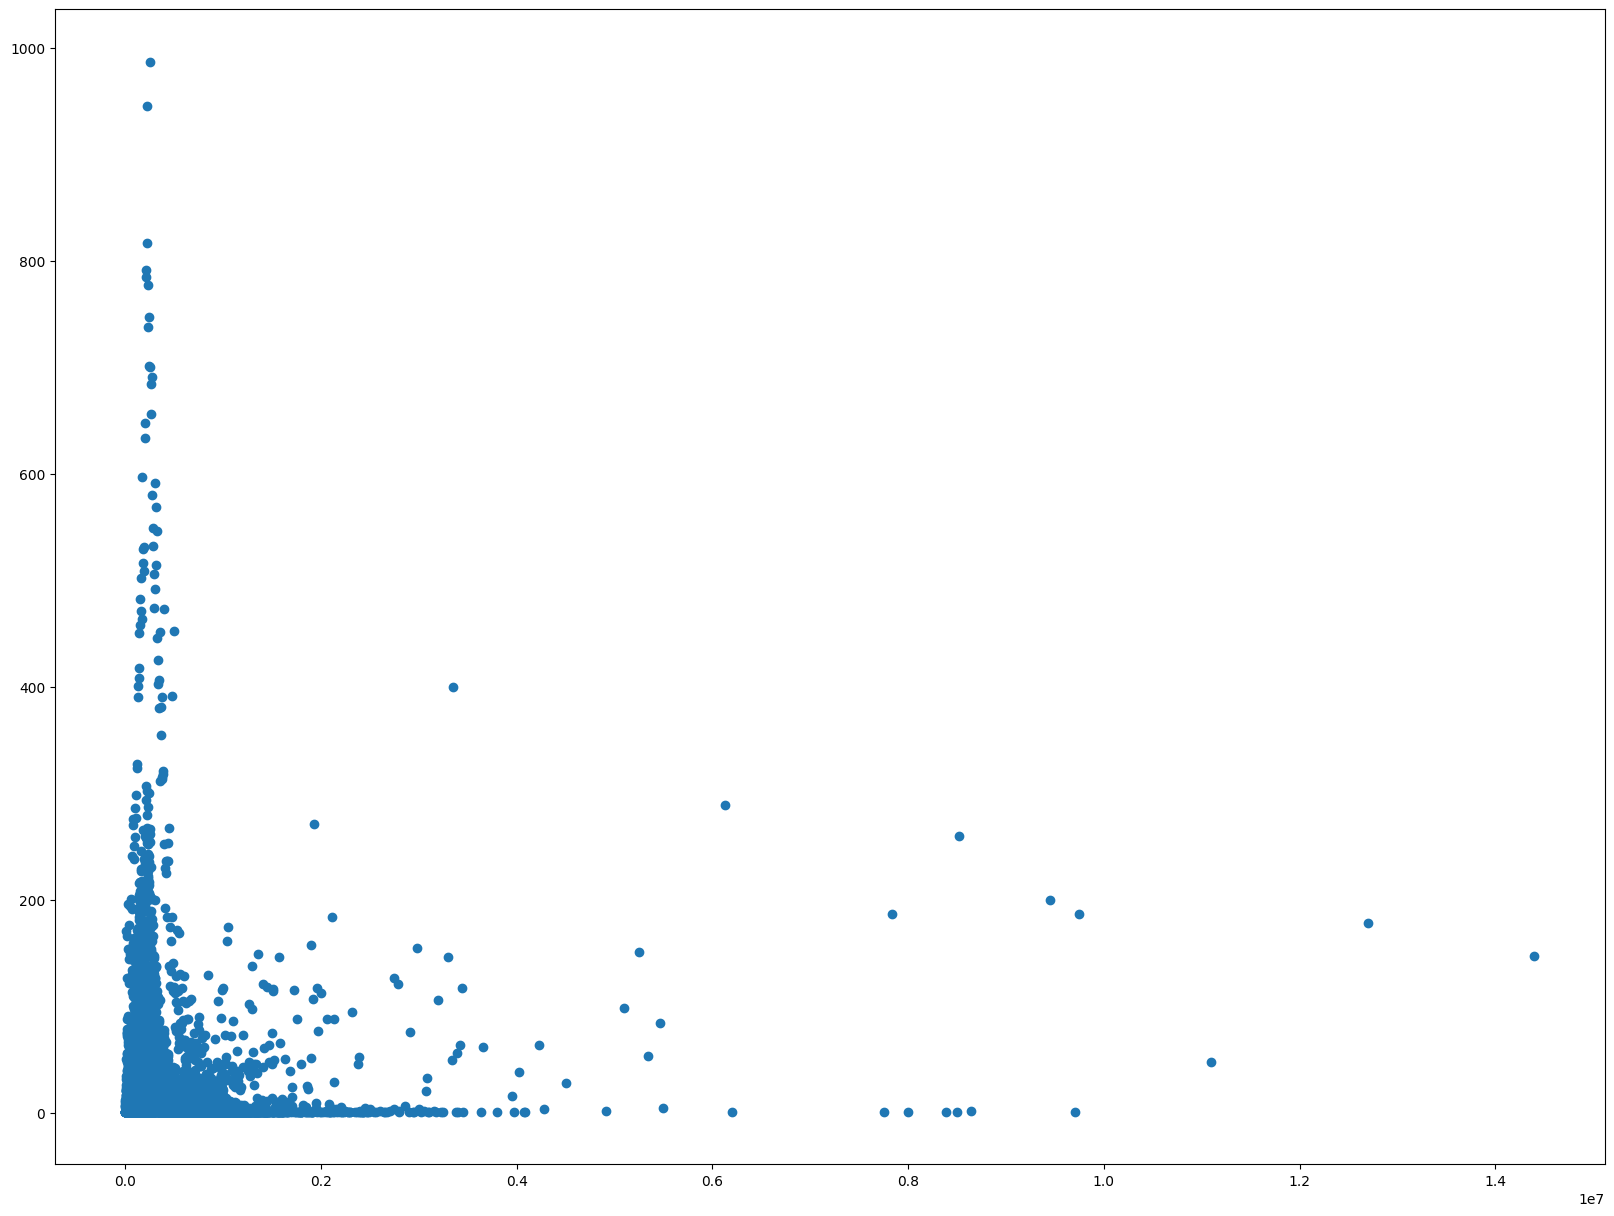

208276
9.3518133182317


In [8]:
# saleprice plot
sale_prices = pd.to_numeric(train_data['sale_price'].replace("", None).dropna())
price_vals = defaultdict(lambda: 0, {})
for ind, item in sale_prices.iteritems():
    price_vals[item] += 1


plt.figure(figsize = (20,15))
plt.scatter(price_vals.keys(), price_vals.values())
plt.show()

print(sum(list(price_vals.values())))
print(sale_prices.skew())

/var/folders/k1/b11hy6gj2wdgdc768yvgls140000gn/T/ipykernel_43102/589899000.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ind, item in sale_prices_no_outliers.iteritems():


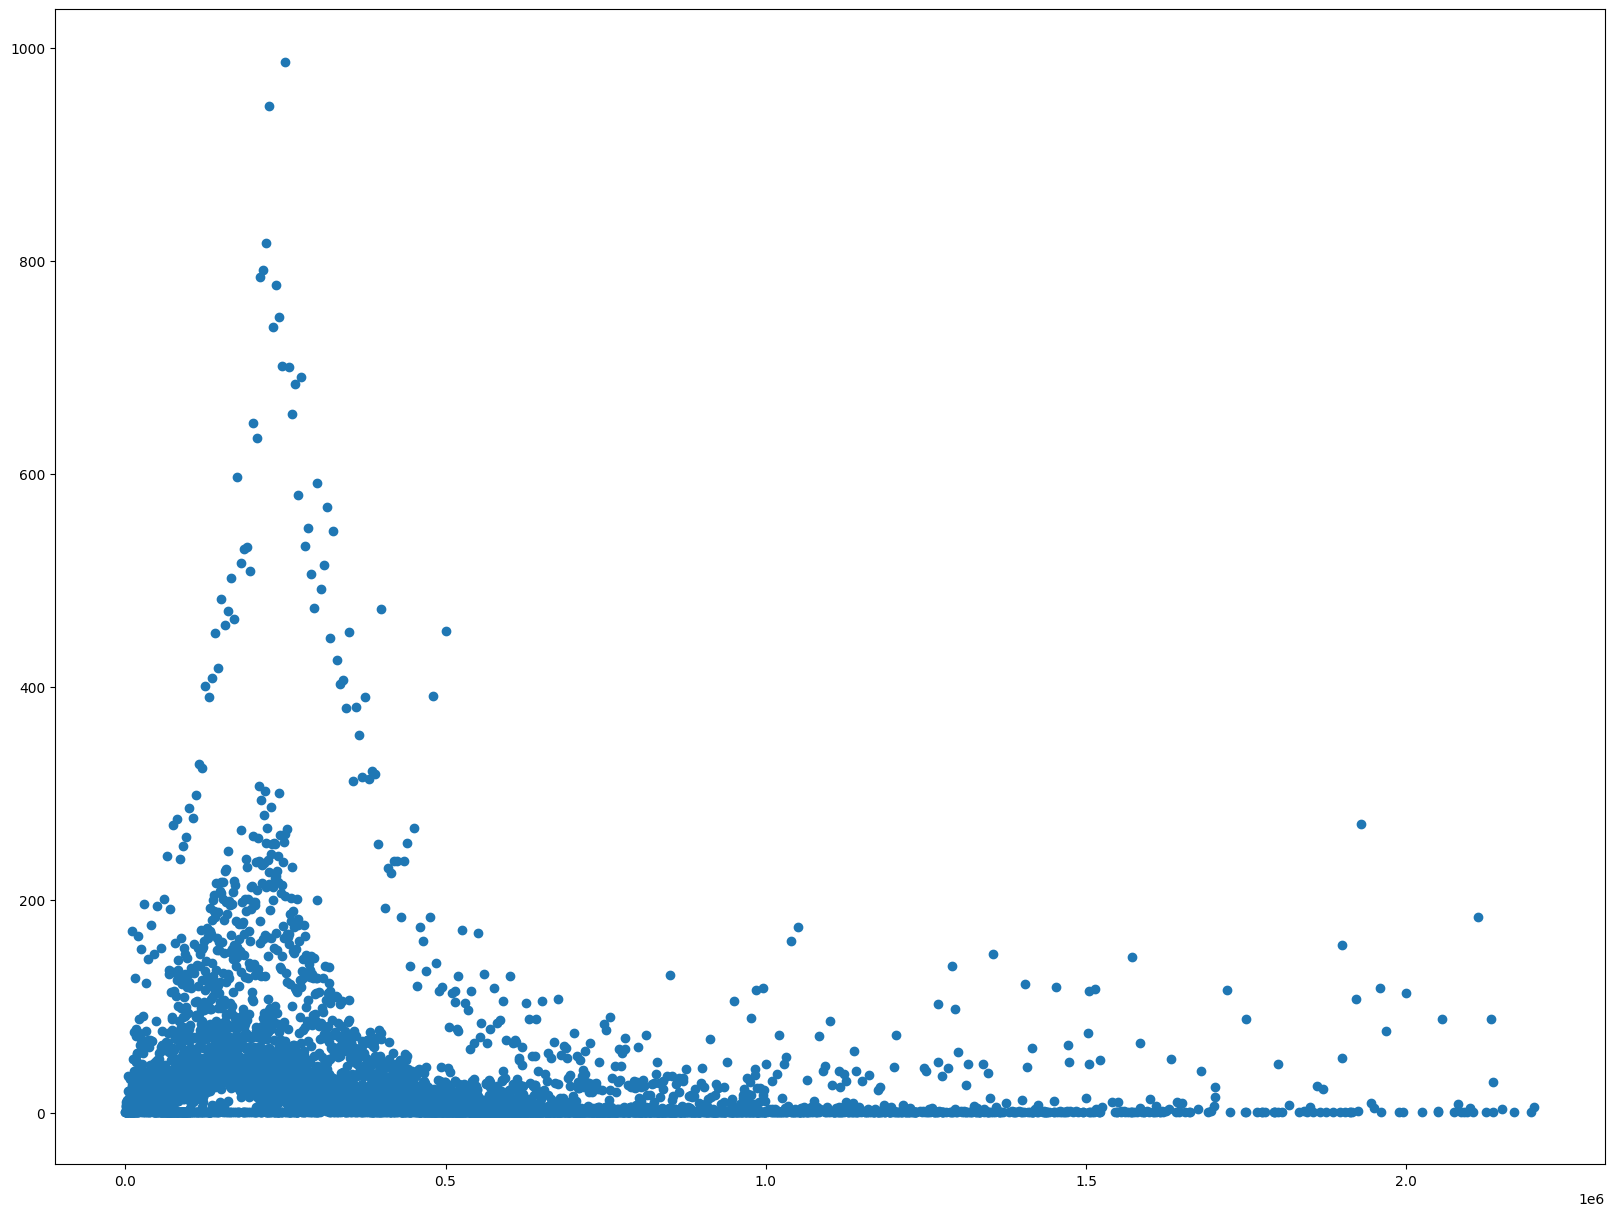

204432
3.544497961686015


In [9]:
# saleprice plot without outliers
sale_prices_no_outliers = sale_prices[np.abs(stats.zscore(stats.zscore(sale_prices))) < 2]
price_vals = defaultdict(lambda: 0, {})
for ind, item in sale_prices_no_outliers.items():
    price_vals[item] += 1


plt.figure(figsize = (20,15))
plt.scatter(price_vals.keys(), price_vals.values())
plt.show()

print(sum(list(price_vals.values())))
print(sale_prices_no_outliers.skew())

/var/folders/k1/b11hy6gj2wdgdc768yvgls140000gn/T/ipykernel_43102/169947937.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ind, item in log_sale_prices.iteritems():


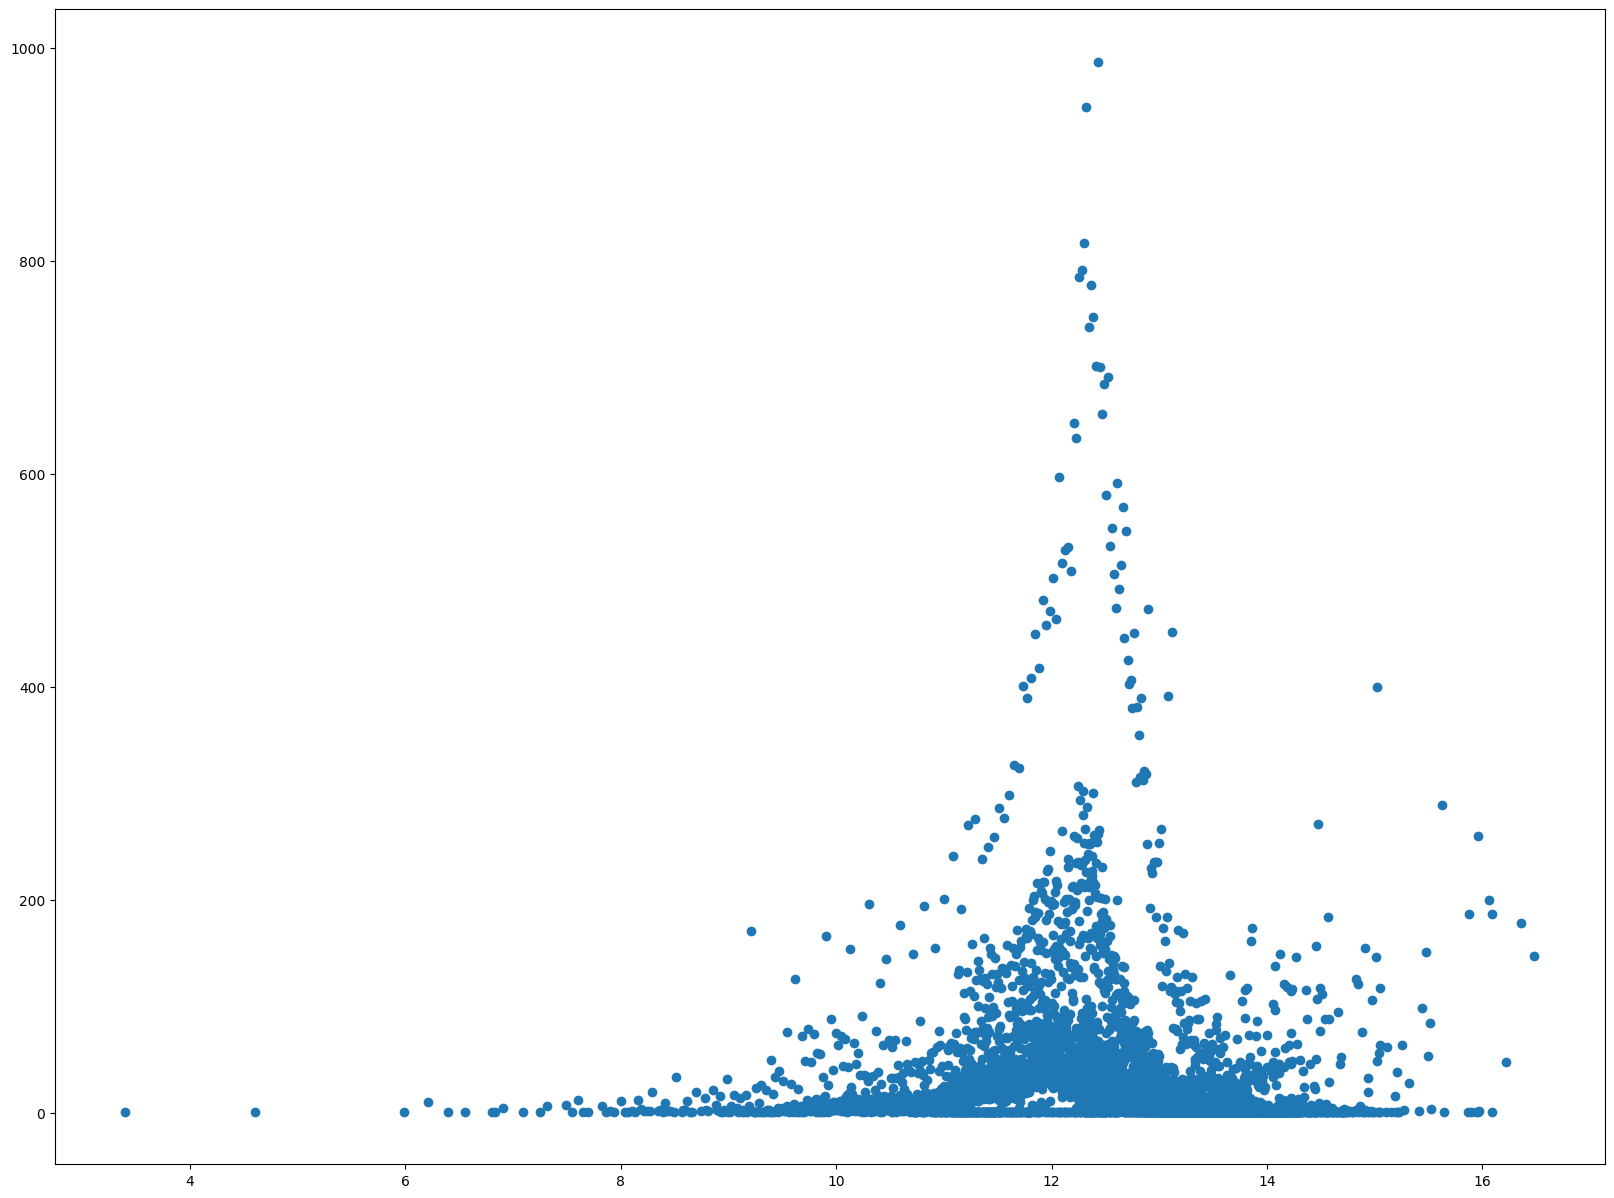

208276
0.4616121001791614


In [10]:
# saleprice plot with log
log_sale_prices = sale_prices.apply(np.log)
price_vals = defaultdict(lambda: 0, {})
for ind, item in log_sale_prices.items():
    price_vals[item] += 1


plt.figure(figsize = (20,15))
plt.scatter(price_vals.keys(), price_vals.values())
plt.show()

print(sum(list(price_vals.values())))
print(log_sale_prices.skew())

/var/folders/k1/b11hy6gj2wdgdc768yvgls140000gn/T/ipykernel_43102/1482745225.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ind, item in pd.Series(box_cox_sale_prices[0]).iteritems():


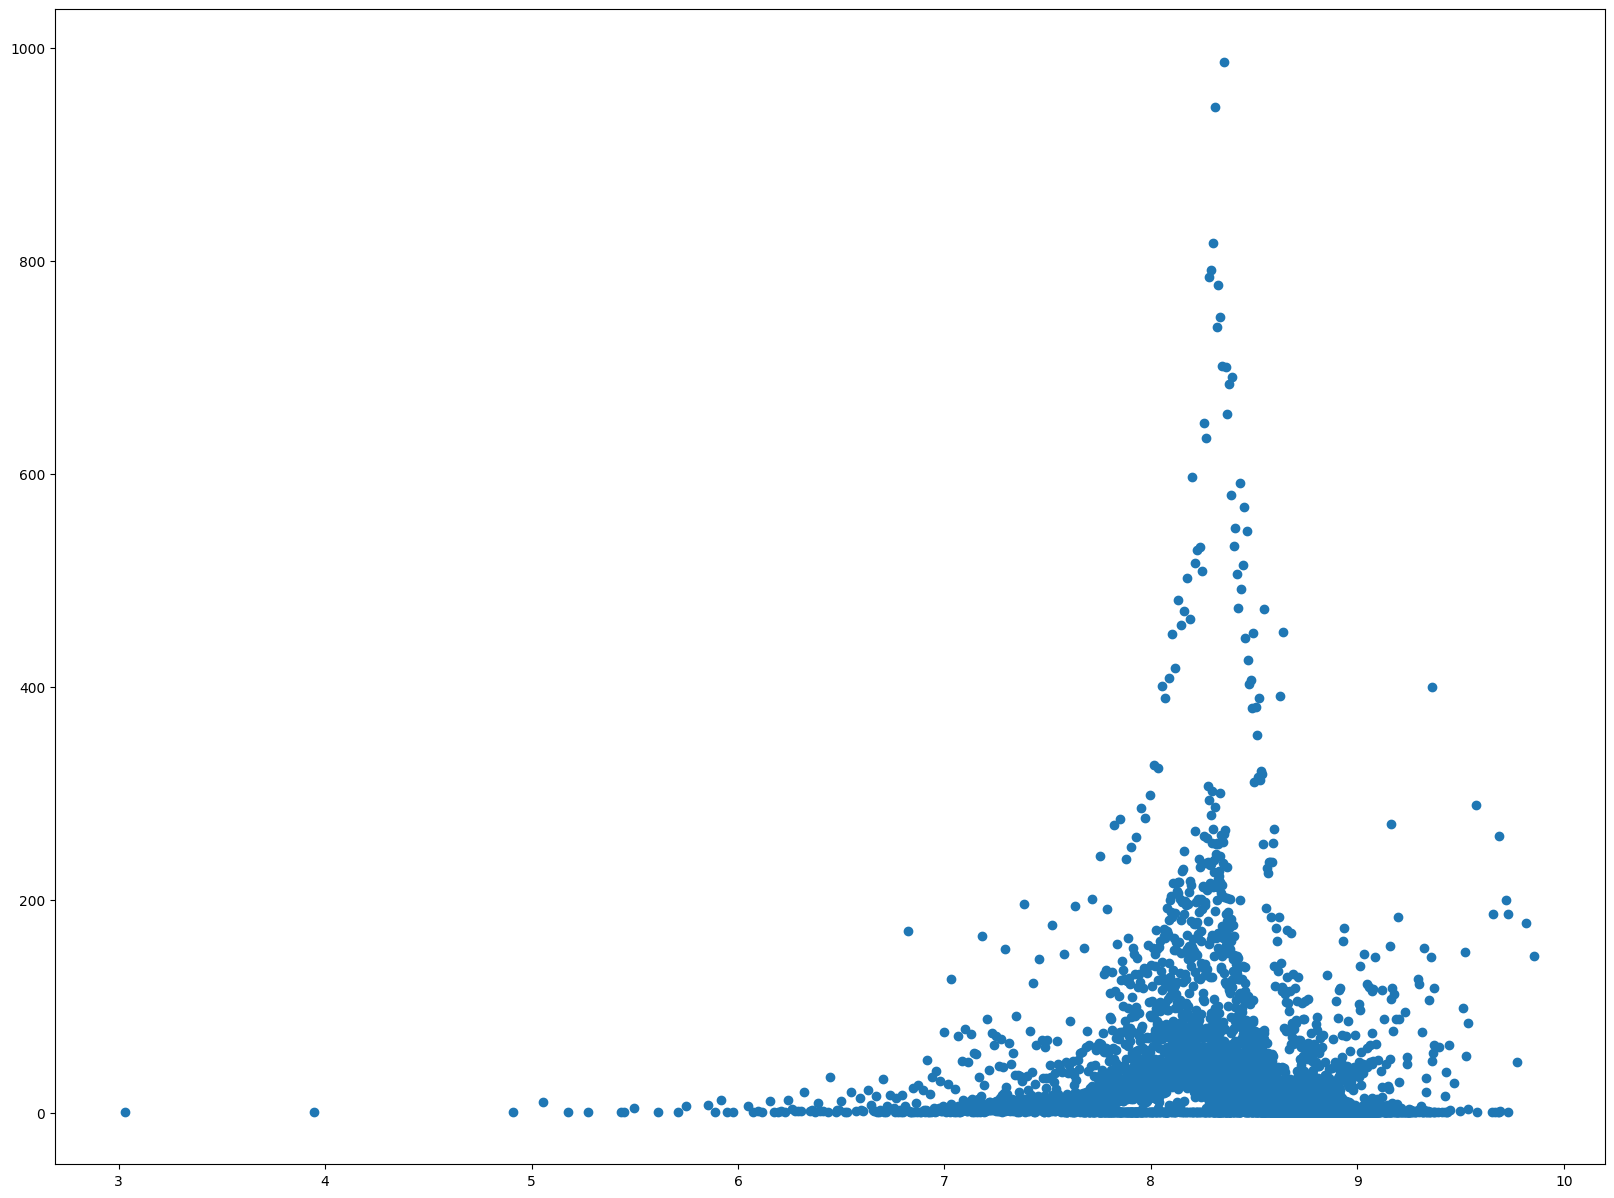

208276
-0.08499810739935112


In [11]:
# saleprice plot with log
box_cox_sale_prices = stats.boxcox(sale_prices)
l = box_cox_sale_prices[1]
price_vals = defaultdict(lambda: 0, {})
for ind, item in pd.Series(box_cox_sale_prices[0]).items():
    price_vals[item] += 1


plt.figure(figsize = (20,15))
plt.scatter(price_vals.keys(), price_vals.values())
plt.show()

print(sum(list(price_vals.values())))
print(pd.Series(box_cox_sale_prices[0]).skew())

### Fixed effects with simple dummies

In [57]:
# one hot encoding on zip codes, quality, condition, hvac, floor type, style/unit type, roof type, exterior type, interior type
zip_dums = pd.get_dummies(train_data['location_zip_code'] , drop_first = True, prefix = "zip")
quality_dums = pd.get_dummies(train_data['quality_code'], drop_first = True, prefix = "quality")
condition_dums = pd.get_dummies(train_data['condition'], drop_first = True, prefix = "condition")
hvac_dums = pd.get_dummies(train_data['hvac'], drop_first = True, prefix = "hvac")
floor_dums = pd.get_dummies(train_data['floor_material_type_code'], drop_first = True, prefix = "floor")
simple_style_dums = pd.get_dummies(train_data['style'], drop_first = True, prefix = "style")
complex_style_dums = pd.get_dummies(train_data['style_unit_type'], drop_first = True, prefix = "style")
roof_dums = pd.get_dummies(train_data['roof_construction_type_code'], drop_first = True, prefix = "roof")
exterior_dums = pd.get_dummies(train_data['exterior_construction_type'], drop_first = True, prefix = "exterior")
interior_dums = pd.get_dummies(train_data['interior_finish_type'], drop_first = True, prefix = "interior")
month_dums = pd.get_dummies(train_data['t_month'], drop_first = True, prefix = "month")
year_dums = pd.get_dummies(train_data['t_year'], drop_first = True, prefix = "year")
neighborhood_dums = pd.get_dummies(train_data['neighborhood_code'], drop_first=True, prefix = "neighborhood")
street_dums = pd.get_dummies(train_data['street'], drop_first=True, prefix = "street")

dummies = pd.concat([zip_dums, quality_dums, condition_dums, hvac_dums, floor_dums, complex_style_dums, roof_dums, exterior_dums, interior_dums, month_dums], axis = 1)

---

# Helper Functions

In [58]:
def error_calc(X_train, X_test, y_train, y_test):
    x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train)
    model= sm.OLS(np.array(y_tr), np.array(x_tr)).fit()

    return (mean_squared_error(model.predict(x_tr), y_tr), mean_squared_error(model.predict(x_te), y_te), mean_squared_error(model.predict(X_test), y_test))

---

# Actual Model Runs

### Model 1

In [59]:
train1 = train_data.loc[:, [
    "total_net_acres",
    "no_of_fireplace",
    "walkout_basement_flag",
    "built_as_sf",
    "no_of_story",
    "average_story_height",
    "most_recent_year",
    "improvement_percent",
    "garage_percent",
    "porch_percent",
    "uf_base_percent",
    "f_base_percent",
    "bath_to_bed",
    "months_from_1983",
    "predict"
]].apply(pd.to_numeric)

train1 = pd.concat([train1, dummies], axis = 1)

test = train1[train1.predict == 1].drop(['predict'], axis = 1)
train1 = train1[train1.predict == 0].drop(['predict'], axis = 1)

train1['target'] = np.log(sale_prices)

# regress using fixed effects on log sale prices
train1 = train1.reset_index().replace("", None).dropna().drop(["index"], axis = 1)

X_train = train1.copy().drop(['target'], axis = 1)
X_train['intercept'] = [1]*len(X_train)
X_train = pd.concat([X_train.iloc[:,-1], X_train.iloc[:, 0:-1]], axis = 1)

model1 = sm.OLS(np.array(train1.target), np.array(X_train)).fit()
model1.summary(yname = "sale_prices", xname = list(X_train.columns))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sale_prices   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     786.5
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:46:52   Log-Likelihood:            -2.2681e+05
No. Observations:              208209   AIC:                         4.539e+05
Df Residuals:                  208095   BIC:                         4.550e+05
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
intercept                                 -6.8555      0.904     -7.583      0.000      -8.627      -5.084
total_net_acres                           -0.0163      0.001    -12.811      0.000      -0.019      -0.014
no_of_fireplace                            0.0201      0.003      5.987      0.000       0.014       0.027
walkout_basement_flag                      0.0072      0.005      1.599      0.110      -0.002       0.016
built_as_sf                                0.0002   3.89e-06     52.831      0.000       0.000       0.000
no_of_story                                0.0257      0.004      6.251      0.000       0.018       0.034
average_story_height                       0.0592      0.003     21.584      0.000       0.054       0.065
most_recent_year                           0.0088      0.000     23.197      0.000       0.008       0.009
improvement_percent                        0.0028      0.380      0.007      0.994      -0.741       0.747
garage_percent                             0.0632      0.021      2.957      0.003       0.021       0.105
porch_percent                             -0.0209      0.016     -1.311      0.190      -0.052       0.010
uf_base_percent                            0.1793      0.009     20.464      0.000       0.162       0.196
f_base_percent                            -0.0286      0.008     -3.383      0.001      -0.045      -0.012
bath_to_bed                                0.0606      0.007      8.961      0.000       0.047       0.074
months_from_1983                           0.0032    2.4e-05    135.163      0.000       0.003       0.003
zip_80104                                  0.5188      0.240      2.162      0.031       0.048       0.989
zip_80106                                  0.8562      0.564      1.517      0.129      -0.250       1.962
zip_80107                                  1.6232      0.565      2.874      0.004       0.516       2.730
zip_80108                                  0.6426      0.240      2.677      0.007       0.172       1.113
zip_80109                                  0.5571      0.240      2.322      0.020       0.087       1.028
zip_80112                                  0.3558      0.244      1.457      0.145      -0.123       0.834
zip_80116                                  0.1223      0.241      0.508      0.611      -0.350       0.594
zip_80118                                 -0.3635      0.240     -1.514      0.130      -0.834       0.107
zip_80124                                  0.6131      0.240      2.555      0.011       0.143       1.084
zip_80125                                  0.2345      0.240      0.977      0.328      -0.236       0.705
zip_80126                                  0.4238      0.240      1.766      0.077     

In [60]:
X_test = test.copy().reset_index().drop(['index'], axis = 1)
X_test['intercept'] = [1]*len(X_test)
X_test = pd.concat([X_test.iloc[:,-1], X_test.iloc[:, 0:-1]], axis = 1)
predictions = np.round(np.exp(model1.predict(X_test)))

test_data = pd.read_csv("TestData.csv")
actuals = test_data['sale_price']

print(np.sum(predictions - actuals)/100000)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pd.DataFrame({"Prediction": predictions, "Actual": actuals}))

258.93457


In [61]:
(error_te_1, error_tr_1, error_actual_1) = error_calc(X_train, X_test, train1.target, np.log(actuals))

### Model 2

In [62]:
dummies2 = pd.concat([zip_dums, condition_dums, complex_style_dums, month_dums], axis = 1)

train2 = train_data.loc[:, [
    "total_net_acres",
    "no_of_fireplace",
    "built_as_sf",
    "no_of_story",
    "average_story_height",
    "most_recent_year",
    "garage_percent",
    "uf_base_percent",
    "f_base_percent",
    "no_of_bedroom",
    "bath_to_bed",
    "months_from_1983",
    "predict"
]].apply(pd.to_numeric)

train2 = pd.concat([train2, dummies2], axis = 1)

test = train2[train2.predict == 1].drop(['predict'], axis = 1)
train2 = train2[train2.predict == 0].drop(['predict'], axis = 1)

train2['target'] = np.log(sale_prices)

# regress using fixed effects on log sale prices
train2 = train2.reset_index().replace("", None).dropna().drop(["index"], axis = 1)

X_train = train2.copy().drop(['target'], axis = 1)
X_train['intercept'] = [1]*len(X_train)
X_train = pd.concat([X_train.iloc[:,-1], X_train.iloc[:, 0:-1]], axis = 1)

model2 = sm.OLS(np.array(train2.target), np.array(X_train)).fit()
model2.summary(yname = "sale_prices", xname = list(X_train.columns))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sale_prices   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     1677.
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:47:00   Log-Likelihood:            -2.2742e+05
No. Observations:              208209   AIC:                         4.549e+05
Df Residuals:                  208156   BIC:                         4.555e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
intercept                                 -9.8928      0.748    -13.222      0.000     -11.359      -8.426
total_net_acres                           -0.0186      0.001    -14.917      0.000      -0.021      -0.016
no_of_fireplace                            0.0179      0.003      5.499      0.000       0.012       0.024
built_as_sf                                0.0002    3.8e-06     47.697      0.000       0.000       0.000
no_of_story                                0.0234      0.004      5.490      0.000       0.015       0.032
average_story_height                       0.0622      0.003     23.783      0.000       0.057       0.067
most_recent_year                           0.0098      0.000     27.196      0.000       0.009       0.011
garage_percent                             0.0494      0.021      2.368      0.018       0.009       0.090
uf_base_percent                            0.1805      0.009     21.199      0.000       0.164       0.197
f_base_percent                            -0.0110      0.008     -1.367      0.172      -0.027       0.005
no_of_bedroom                              0.0331      0.004      8.666      0.000       0.026       0.041
bath_to_bed                                0.0884      0.009      9.998      0.000       0.071       0.106
months_from_1983                           0.0033   2.33e-05    143.367      0.000       0.003       0.003
zip_80104                                  0.4933      0.241      2.051      0.040       0.022       0.965
zip_80106                                  0.6738      0.566      1.191      0.234      -0.435       1.782
zip_80107                                  1.6448      0.566      2.905      0.004       0.535       2.754
zip_80108                                  0.6198      0.241      2.576      0.010       0.148       1.091
zip_80109                                  0.5247      0.241      2.181      0.029       0.053       0.996
zip_80112                                  0.3315      0.245      1.354      0.176      -0.148       0.811
zip_80116                                  0.1094      0.241      0.453      0.651      -0.364       0.582
zip_80118                                 -0.4114      0.241     -1.709      0.088      -0.883       0.061
zip_80124                                  0.5870      0.241      2.440      0.015       0.115       1.059
zip_80125                                  0.1983      0.241      0.824      0.410      -0.273       0.670
zip_80126                                  0.4037      0.241      1.678      0.093      -0.068       0.875
zip_80129                                  0.4331      0.241      1.800      0.072      -0.038       0.905
zip_80130                                  0.4486      0.241      1.865      0.062     

In [63]:
X_test = test.copy().reset_index().drop(['index'], axis = 1)
X_test['intercept'] = [1]*len(X_test)
X_test = pd.concat([X_test.iloc[:,-1], X_test.iloc[:, 0:-1]], axis = 1)
predictions = np.round(np.exp(model2.predict(X_test)))

print(np.sum(predictions - actuals)/100000)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pd.DataFrame({"Prediction": predictions, "Actual": actuals}))

265.74584


In [64]:
(error_te_2, error_tr_2, error_actual_2) = error_calc(X_train, X_test, train2.target, np.log(actuals))

### Model 3

In [81]:
dummies3 = pd.concat([zip_dums, complex_style_dums, month_dums, year_dums], axis = 1)

train3 = train_data.loc[:, [
    "no_of_fireplace",
    "built_as_sf",
    "no_of_story",
    "average_story_height",
    "most_recent_year",
    "uf_base_percent",
    "no_of_bedroom",
    "bath_to_bed",
    "predict"
]].apply(pd.to_numeric)

train3 = pd.concat([train3, dummies3], axis = 1)

test = train3[train3.predict == 1].drop(['predict'], axis = 1)
train3 = train3[train3.predict == 0].drop(['predict'], axis = 1)

train3['target'] = np.log(sale_prices)

# regress using fixed effects on log sale prices
train3 = train3.reset_index().replace("", None).dropna().drop(["index"], axis = 1)

X_train = train3.copy().drop(['target'], axis = 1)
X_train['intercept'] = [1]*len(X_train)
X_train = pd.concat([X_train.iloc[:,-1], X_train.iloc[:, 0:-1]], axis = 1)

model3 = sm.OLS(np.array(train3.target), np.array(X_train)).fit()
model3.summary(yname = "sale_prices", xname = list(X_train.columns))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sale_prices   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     1406.
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:28:52   Log-Likelihood:            -2.2259e+05
No. Observations:              208209   AIC:                         4.453e+05
Df Residuals:                  208136   BIC:                         4.461e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
intercept                                 -5.1021      0.603     -8.468      0.000      -6.283      -3.921
no_of_fireplace                            0.0193      0.003      6.164      0.000       0.013       0.025
built_as_sf                                0.0002   3.57e-06     52.035      0.000       0.000       0.000
no_of_story                                0.0205      0.004      4.955      0.000       0.012       0.029
average_story_height                       0.0567      0.003     21.908      0.000       0.052       0.062
most_recent_year                           0.0074      0.000     26.243      0.000       0.007       0.008
uf_base_percent                            0.1844      0.007     25.206      0.000       0.170       0.199
no_of_bedroom                              0.0374      0.004     10.056      0.000       0.030       0.045
bath_to_bed                                0.0916      0.009     10.700      0.000       0.075       0.108
zip_80104                                  0.1875      0.235      0.797      0.425      -0.273       0.648
zip_80106                                 -0.2857      0.551     -0.518      0.604      -1.366       0.795
zip_80107                                  0.5407      0.551      0.981      0.327      -0.540       1.621
zip_80108                                  0.3195      0.235      1.358      0.174      -0.142       0.780
zip_80109                                  0.2525      0.235      1.074      0.283      -0.208       0.714
zip_80112                                  0.1076      0.239      0.450      0.653      -0.361       0.577
zip_80116                                 -0.2143      0.236     -0.909      0.363      -0.677       0.248
zip_80118                                 -0.7102      0.235     -3.018      0.003      -1.172      -0.249
zip_80124                                  0.2905      0.235      1.235      0.217      -0.170       0.752
zip_80125                                 -0.0818      0.235     -0.348      0.728      -0.543       0.379
zip_80126                                  0.1390      0.235      0.591      0.554      -0.322       0.600
zip_80129                                  0.1389      0.235      0.591      0.555      -0.322       0.600
zip_80130                                  0.1723      0.235      0.733      0.464      -0.289       0.633
zip_80131                                  0.0108      0.243      0.044      0.965      -0.466       0.487
zip_80133                                 -0.4222      0.470     -0.898      0.369      -1.344       0.499
zip_80134                                  0.0768      0.235      0.327      0.744      -0.384       0.538
zip_80135                                 -0.4764      0.236     -2.017      0.044     

In [86]:
X_test = test.copy().reset_index().drop(['index'], axis = 1)
X_test['intercept'] = [1]*len(X_test)
X_test = pd.concat([X_test.iloc[:,-1], X_test.iloc[:, 0:-1]], axis = 1)
predictions = np.round(np.exp(model3.predict(X_test)))

print(np.sum(predictions - actuals)/100000)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.concat([pd.DataFrame({"Prediction": predictions, "Actual": actuals, "Difference": np.abs(predictions - actuals)}), test.reset_index().drop(['index'], axis =1)], axis = 1))

35.6618


,Prediction,Actual,Difference,no_of_fireplace,built_as_sf,no_of_story,average_story_height,most_recent_year,uf_base_percent,no_of_bedroom,bath_to_bed,zip_80104,zip_80106,zip_80107,zip_80108,zip_80109,zip_80112,zip_80116,zip_80118,zip_80124,zip_80125,zip_80126,zip_80129,zip_80130,zip_80131,zip_80133,zip_80134,zip_80135,zip_80138,style_Condominium unit_Inside,style_Single Family Residential,style_Single Family Residential_End,style_Single Family Residential_Inside,style_Townhouse_End,style_Townhouse_Inside,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,year_1984,year_1985,year_1986,year_1987,year_1988,year_1989,year_1990,year_1991,year_1992,year_1993,year_1994,year_1995,year_1996,year_1997,year_1998,year_1999,year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012
0,333273.0,375000,41727.0,2,3292,1.0,10.0,1989.0,0.000000,4,0.750000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,357739.0,590000,232261.0,1,4994,2.0,11.0,2008.0,0.749099,4,1.250000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,237753.0,250000,12247.0,0,1330,1.0,8.0,1990.0,0.000000,2,0.500000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,236073.0,190000,46073.0,0,1092,1.0,8.0,1965.0,0.923077,3,0.666667,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,364324.0,520000,155676.0,1,4174,1.0,8.0,1972.0,0.000000,4,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,279915.0,481000,201085.0,1,2276,1.0,8.0,1981.0,0.246046,4,0.750000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,285998.0,250000,35998.0,1,1756,1.0,8.0,1985.0,1.006834,2,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,300017.0,400000,99983.0,2,2385,1.0,8.0,1978.0,0.528302,4,0.750000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,316354.0,345000,28646.0,0,2720,2.0,8.0,1992.0,0.091176,3,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,275317.0,290400,15083.0,1,1840,2.0,8.0,1984.0,0.456522,3,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [67]:
(error_te_3, error_tr_3, error_actual_3) = error_calc(X_train, X_test, train3.target, np.log(actuals))

### Model 4

In [68]:
dummies4 = pd.concat([neighborhood_dums, complex_style_dums, month_dums, year_dums], axis = 1)

train4 = train_data.loc[:, [
    "no_of_fireplace",
    "built_as_sf",
    "no_of_story",
    "average_story_height",
    "most_recent_year",
    "uf_base_percent",
    "no_of_bedroom",
    "bath_to_bed",
    "predict"
]].apply(pd.to_numeric)

train4 = pd.concat([train4, dummies4], axis = 1)

test = train4[train4.predict == 1].drop(['predict'], axis = 1)
train4 = train4[train4.predict == 0].drop(['predict'], axis = 1)

train4['target'] = np.log(sale_prices)

# regress using fixed effects on log sale prices
train4 = train4.reset_index().replace("", None).dropna().drop(["index"], axis = 1)

X_train = train4.copy().drop(['target'], axis = 1)
X_train['intercept'] = [1]*len(X_train)
X_train = pd.concat([X_train.iloc[:,-1], X_train.iloc[:, 0:-1]], axis = 1)

model4 = sm.OLS(np.array(train4.target), np.array(X_train)).fit()
model4.summary(yname = "sale_prices", xname = list(X_train.columns))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sale_prices   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     718.5
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:47:19   Log-Likelihood:            -2.1620e+05
No. Observations:              208209   AIC:                         4.327e+05
Df Residuals:                  208040   BIC:                         4.345e+05
Df Model:                         168                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
intercept                                  7.0243      0.561     12.532      0.000       5.926       8.123
no_of_fireplace                            0.0396      0.003     12.756      0.000       0.034       0.046
built_as_sf                                0.0002   3.86e-06     48.212      0.000       0.000       0.000
no_of_story                               -0.0109      0.004     -2.622      0.009      -0.019      -0.003
average_story_height                       0.0593      0.003     22.493      0.000       0.054       0.064
most_recent_year                           0.0011      0.000      3.518      0.000       0.000       0.002
uf_base_percent                            0.2006      0.007     27.256      0.000       0.186       0.215
no_of_bedroom                              0.0389      0.004     10.635      0.000       0.032       0.046
bath_to_bed                                0.1233      0.008     14.524      0.000       0.107       0.140
neighborhood_101                          -0.1490      0.157     -0.947      0.343      -0.457       0.159
neighborhood_102                          -0.4224      0.159     -2.665      0.008      -0.733      -0.112
neighborhood_103                           0.1122      0.158      0.709      0.478      -0.198       0.422
neighborhood_104                          -0.4595      0.158     -2.899      0.004      -0.770      -0.149
neighborhood_105                          -0.5784      0.160     -3.617      0.000      -0.892      -0.265
neighborhood_106                          -0.2956      0.158     -1.869      0.062      -0.606       0.014
neighborhood_107                          -0.2389      0.277     -0.863      0.388      -0.781       0.304
neighborhood_109                          -0.4308      0.157     -2.741      0.006      -0.739      -0.123
neighborhood_110                          -0.1329      0.157     -0.846      0.398      -0.441       0.175
neighborhood_111                          -0.3926      0.158     -2.482      0.013      -0.703      -0.083
neighborhood_112                          -0.0170      0.157     -0.108      0.914      -0.325       0.291
neighborhood_115                          -0.1583      0.196     -0.808      0.419      -0.542       0.226
neighborhood_116                          -0.1680      0.157     -1.068      0.285      -0.476       0.140
neighborhood_117                          -0.2329      0.160     -1.456      0.145      -0.546       0.081
neighborhood_118                          -0.2132      0.157     -1.354      0.176      -0.522       0.095
neighborhood_119                          -0.2827      0.159     -1.781      0.075      -0.594       0.028
neighborhood_120                          -0.3602      0.179     -2.015      0.044     

In [69]:
X_test = test.copy().reset_index().drop(['index'], axis = 1)
X_test['intercept'] = [1]*len(X_test)
X_test = pd.concat([X_test.iloc[:,-1], X_test.iloc[:, 0:-1]], axis = 1)
predictions = np.round(np.exp(model4.predict(X_test)))

print(np.sum(predictions - actuals)/100000)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pd.DataFrame({"Prediction": predictions, "Actual": actuals}))

56.69677


In [70]:
(error_te_4, error_tr_4, error_actual_4) = error_calc(X_train, X_test, train4.target, np.log(actuals))

## Model 5

In [71]:
dummies5 = pd.concat([zip_dums, simple_style_dums, month_dums, year_dums], axis = 1)
dummies5.style_Townhouse = train_data.end_unit*dummies5.style_Townhouse

train5 = train_data.loc[:, [
    "total_net_acres",
    "no_of_fireplace",
    "built_as_sf",
    "no_of_story",
    "average_story_height",
    "most_recent_year",
    "uf_base_percent",
    "no_of_bedroom",
    "bath_to_bed",
    "predict"
]].apply(pd.to_numeric)

train5 = pd.concat([train5, dummies5], axis = 1)

test = train5[train5.predict == 1].drop(['predict'], axis = 1)
train5 = train5[train5.predict == 0].drop(['predict'], axis = 1)

train5['target'] = np.log(sale_prices)

# regress using fixed effects on log sale prices
train5 = train5.reset_index().replace("", None).dropna().drop(["index"], axis = 1)

X_train = train5.copy().drop(['target'], axis = 1)
X_train['intercept'] = [1]*len(X_train)
X_train = pd.concat([X_train.iloc[:,-1], X_train.iloc[:, 0:-1]], axis = 1)

model5 = sm.OLS(np.array(train5.target), np.array(X_train)).fit()
model5.summary(yname = "sale_prices", xname = list(X_train.columns))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sale_prices   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     1469.
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:47:31   Log-Likelihood:            -2.2253e+05
No. Observations:              208209   AIC:                         4.452e+05
Df Residuals:                  208139   BIC:                         4.459e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept                          -4.9809      0.602     -8.273      0.000      -6.161      -3.801
total_net_acres                    -0.0177      0.001    -14.673      0.000      -0.020      -0.015
no_of_fireplace                     0.0201      0.003      6.413      0.000       0.014       0.026
built_as_sf                         0.0002    3.6e-06     53.823      0.000       0.000       0.000
no_of_story                         0.0138      0.004      3.342      0.001       0.006       0.022
average_story_height                0.0573      0.003     22.154      0.000       0.052       0.062
most_recent_year                    0.0073      0.000     25.973      0.000       0.007       0.008
uf_base_percent                     0.1880      0.007     25.707      0.000       0.174       0.202
no_of_bedroom                       0.0362      0.004      9.749      0.000       0.029       0.044
bath_to_bed                         0.0949      0.009     11.088      0.000       0.078       0.112
zip_80104                           0.1929      0.235      0.821      0.412      -0.268       0.654
zip_80106                           0.3325      0.553      0.602      0.547      -0.751       1.416
zip_80107                           1.2425      0.553      2.246      0.025       0.158       2.327
zip_80108                           0.3231      0.235      1.374      0.169      -0.138       0.784
zip_80109                           0.2612      0.235      1.111      0.267      -0.200       0.722
zip_80112                           0.1082      0.239      0.452      0.651      -0.361       0.577
zip_80116                          -0.1200      0.236     -0.509      0.611      -0.582       0.342
zip_80118                          -0.6800      0.235     -2.890      0.004      -1.141      -0.219
zip_80124                           0.2910      0.235      1.238      0.216      -0.170       0.752
zip_80125                          -0.0778      0.235     -0.331      0.741      -0.539       0.383
zip_80126                           0.1429      0.235      0.608      0.543      -0.318       0.604
zip_80129                           0.1438      0.235      0.612      0.541      -0.317       0.605
zip_80130                           0.1752      0.235      0.745      0.456      -0.286       0.636
zip_80131                           0.0173      0.243      0.071      0.943      -0.459       0.494
zip_80133                          -0.3202      0.470     -0.681      0.496      -1.241       0.601
zip_80134                           0.0819      0.235      0.348      0.728      -0.379       0.543
zip_80135                          -0.3649      0.236     -1.545      0.122      -0.828       0.098
zip_80138                           0.0850      0.235      0.362      0.718      -0

In [72]:
X_test = test.copy().reset_index().drop(['index'], axis = 1)
X_test['intercept'] = [1]*len(X_test)
X_test = pd.concat([X_test.iloc[:,-1], X_test.iloc[:, 0:-1]], axis = 1)
predictions = np.round(np.exp(model5.predict(X_test)))

print(np.sum(predictions - actuals)/100000)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pd.DataFrame({"Prediction": predictions, "Actual": actuals}))

35.11055


In [73]:
(error_te_5, error_tr_5, error_actual_5) = error_calc(X_train, X_test, train5.target, np.log(actuals))

---

# Error

In [74]:
tr_errors = [error_tr_1, error_tr_2, error_tr_3, error_tr_4, error_te_5]
te_errors = [error_te_1, error_te_2, error_te_3, error_te_4, error_tr_5]
actual_errors = [error_actual_1, error_actual_2, error_actual_3, error_actual_4, error_actual_5]
model_names = ["Model 1: all variables, zip code fixed effects, with month counter", "Model 2: first trimming of variables, zip code fixed effects, with month counter", "Model 3: large trimming of variables, zip code fixed effects, month and year dummies", "Model 4: large trimming of variables, neighborhood fixed effects, month and year dummies", "Model 5: simplify style variables, zip code fixed effects, month and year dummies"]
error_df = pd.DataFrame({"Model": model_names, "Training Error": tr_errors, "Validation Error": te_errors, "Test Error": actual_errors})

error_df2 = error_df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center'), ('font-size', '20pt')])])

error_df2.set_properties(**{'text-align': 'center', "font-size": "16pt"}).hide(axis = "index")

Model,Training Error,Validation Error,Test Error
"Model 1: all variables, zip code fixed effects, with month counter",0.521735,0.516039,0.263339
"Model 2: first trimming of variables, zip code fixed effects, with month counter",0.519084,0.520756,0.256923
"Model 3: large trimming of variables, zip code fixed effects, month and year dummies",0.501116,0.495286,0.125176
"Model 4: large trimming of variables, neighborhood fixed effects, month and year dummies",0.460945,0.469391,0.169770
"Model 5: simplify style variables, zip code fixed effects, month and year dummies",0.497726,0.492803,0.131329


In [75]:
train_data.to_csv("training_final.csv")

---

# Messing Around

In [76]:
subframe = train_data[train_data['sale_price'] != ""].loc[:, ["sale_price", "months_from_1983"]]
subframe.sale_price = pd.to_numeric(subframe.sale_price)
sale_averages = subframe.groupby(["months_from_1983"]).agg(np.mean)['sale_price']

In [77]:
month_dic_reverse = {1: "jan", 2: "feb", 3:"mar", 4:"apr", 
                    5:"may", 6: "jun", 7: "jul", 8: "aug",
                    9: "sep", 10: "oct", 11: "nov", 12: "dec"}

# month_and_intercept = pd.DataFrame({"intercept": [1]*len(sale_averages), "months_from_1983": sale_averages.index})
month_and_intercept = pd.DataFrame({"months_from_1983": sale_averages.index})
month_and_intercept = pd.concat([month_and_intercept, pd.get_dummies([month_dic_reverse[(i-1)%12 + 1] for i in sale_averages.index], drop_first=True, prefix ="month")], axis = 1)

time_trend = sm.OLS(list(sale_averages.values), np.array(month_and_intercept)).fit()
time_trend.summary(yname = "sale_price", xname= list(month_and_intercept.columns))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             sale_price   R-squared (uncentered):                   0.578
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                              39.24
Date:                Wed, 05 Oct 2022   Prob (F-statistic):                    3.40e-57
Time:                        19:47:45   Log-Likelihood:                         -4965.0
No. Observations:                 356   AIC:                                      9954.
Df Residuals:                     344   BIC:                                  1.000e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
months_from_1983  1059.7857    129.030      8.213      0.000     805.999    1313.572
month_aug         4.686e+04   5.64e+04      0.831      0.406    -6.4e+04    1.58e+05
month_dec         1.655e+05   5.71e+04      2.901      0.004    5.33e+04    2.78e+05
month_feb         1.904e+05   5.72e+04      3.331      0.001     7.8e+04    3.03e+05
month_jan         1.206e+05   5.81e+04      2.074      0.039    6237.679    2.35e+05
month_jul         1.083e+05   5.63e+04      1.923      0.055   -2456.795    2.19e+05
month_jun         1.423e+05   5.63e+04      2.529      0.012    3.16e+04    2.53e+05
month_mar         1.485e+05   5.61e+04      2.647      0.009    3.81e+04    2.59e+05
month_may         8.949e+04   5.62e+04      1.592      0.112   -2.11e+04       2e+05
month_nov         1.127e+05   5.65e+04      1.994      0.047    1544.525    2.24e+05
month_oct         8.396e+04   5.65e+04      1.487      0.138   -2.71e+04    1.95e+05
month_sep         8.662e+04   5.64e+04      1.535      0.126   -2.43e+04    1.98e+05
==============================================================================
Omnibus:                      392.620   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14867.556
Skew:                           5.023   Prob(JB):                         0.00
Kurtosis:                      33.023   Cond. No.                     1.31e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

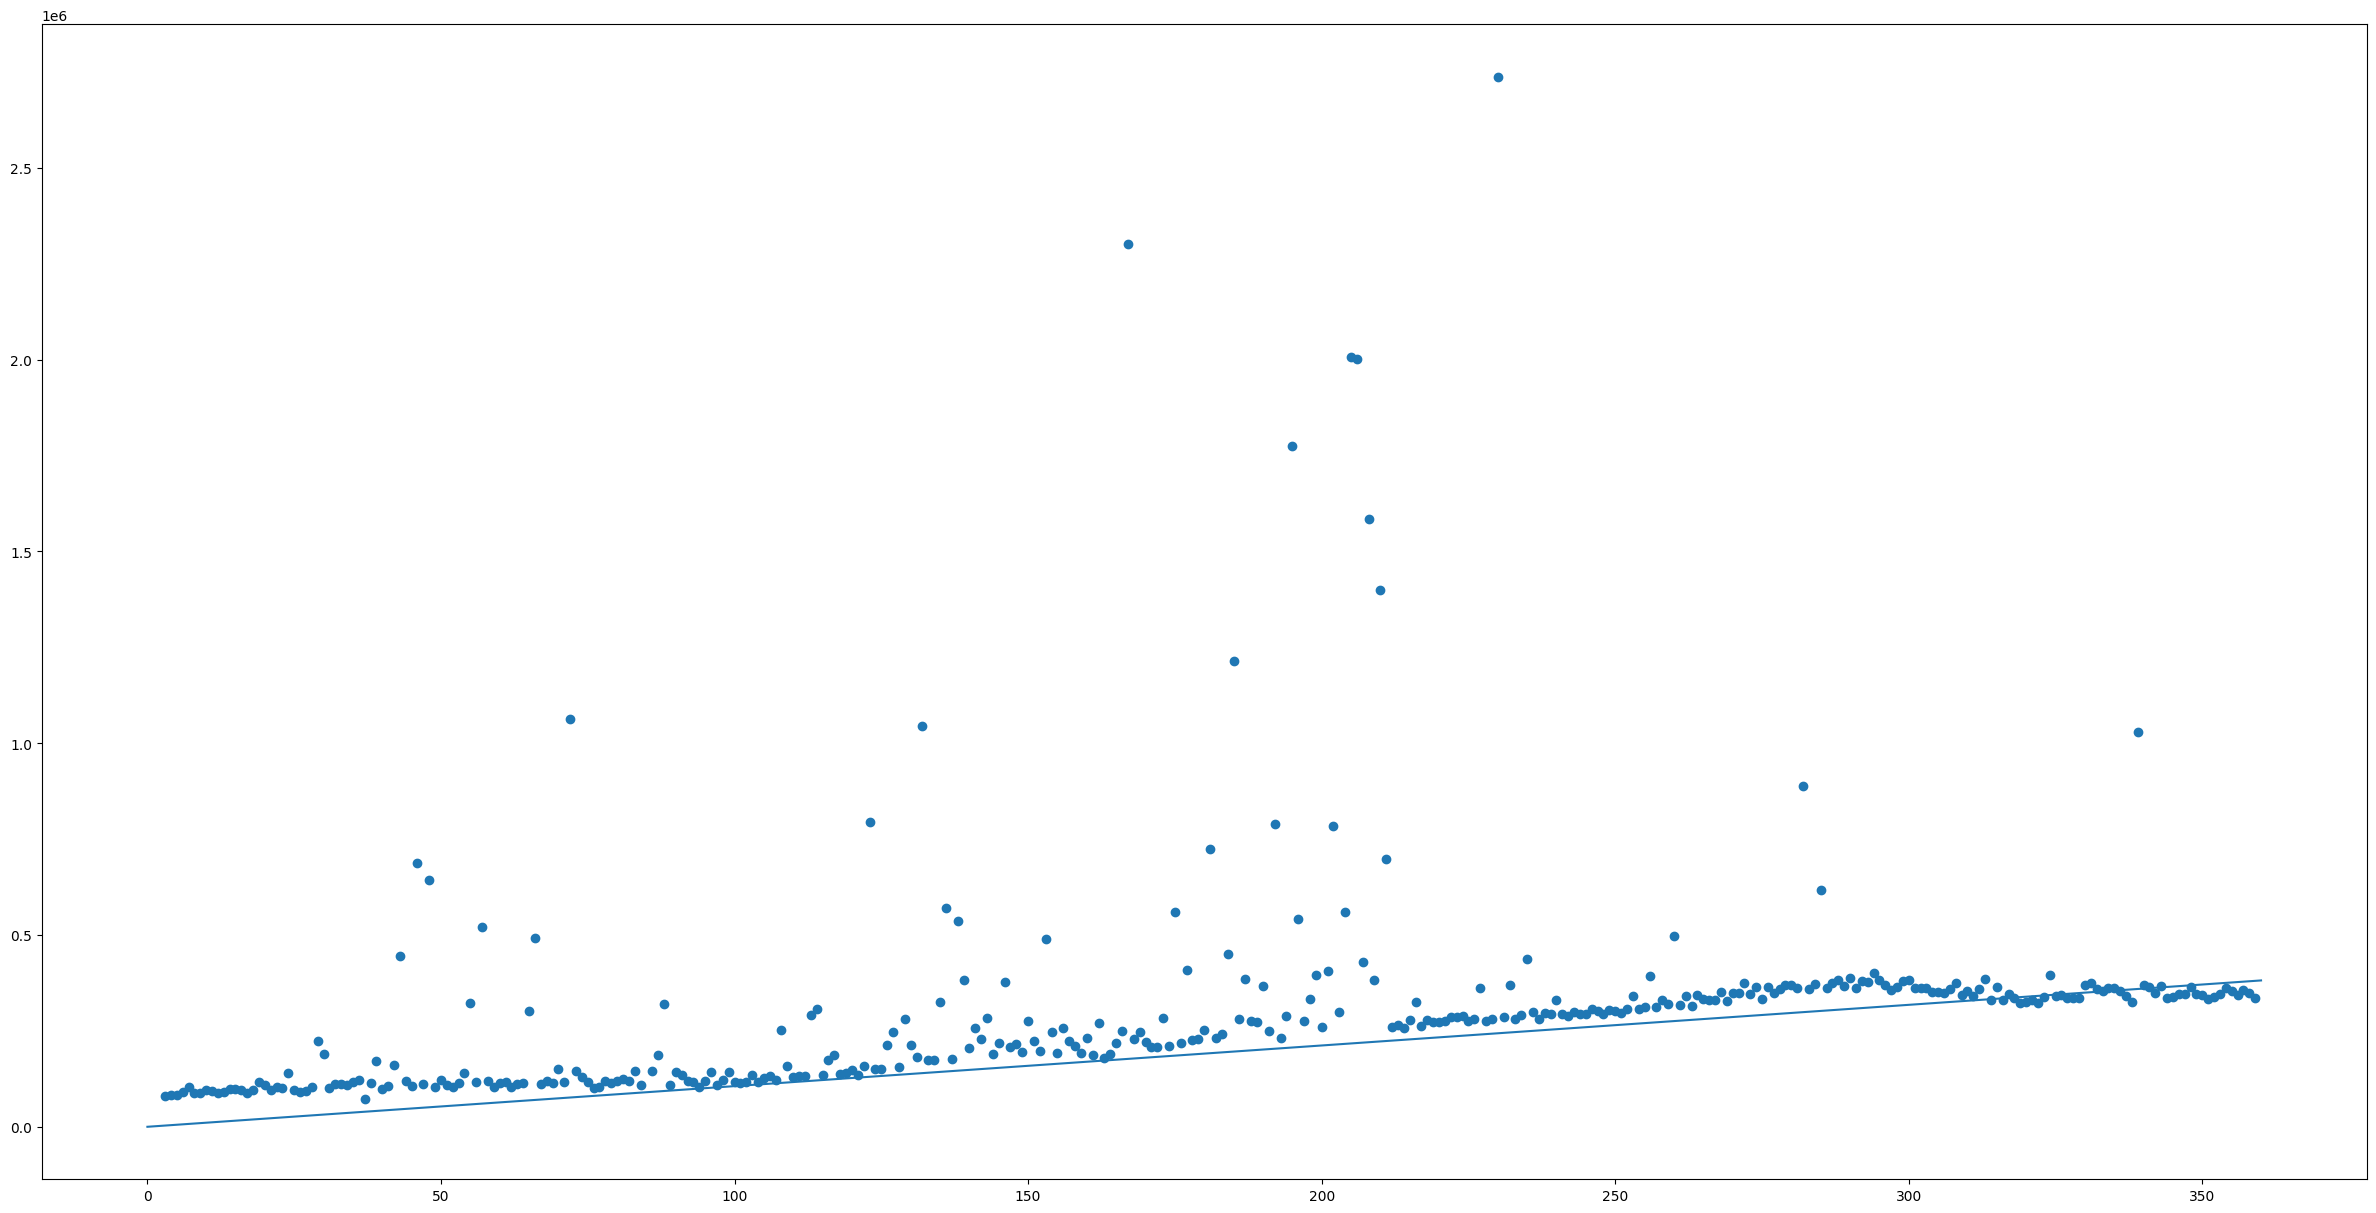

In [78]:
plt.figure(figsize = (30,15))
plt.scatter(sale_averages.index, sale_averages.values)
plt.plot([0,360], [0, (1059.7857*360)])

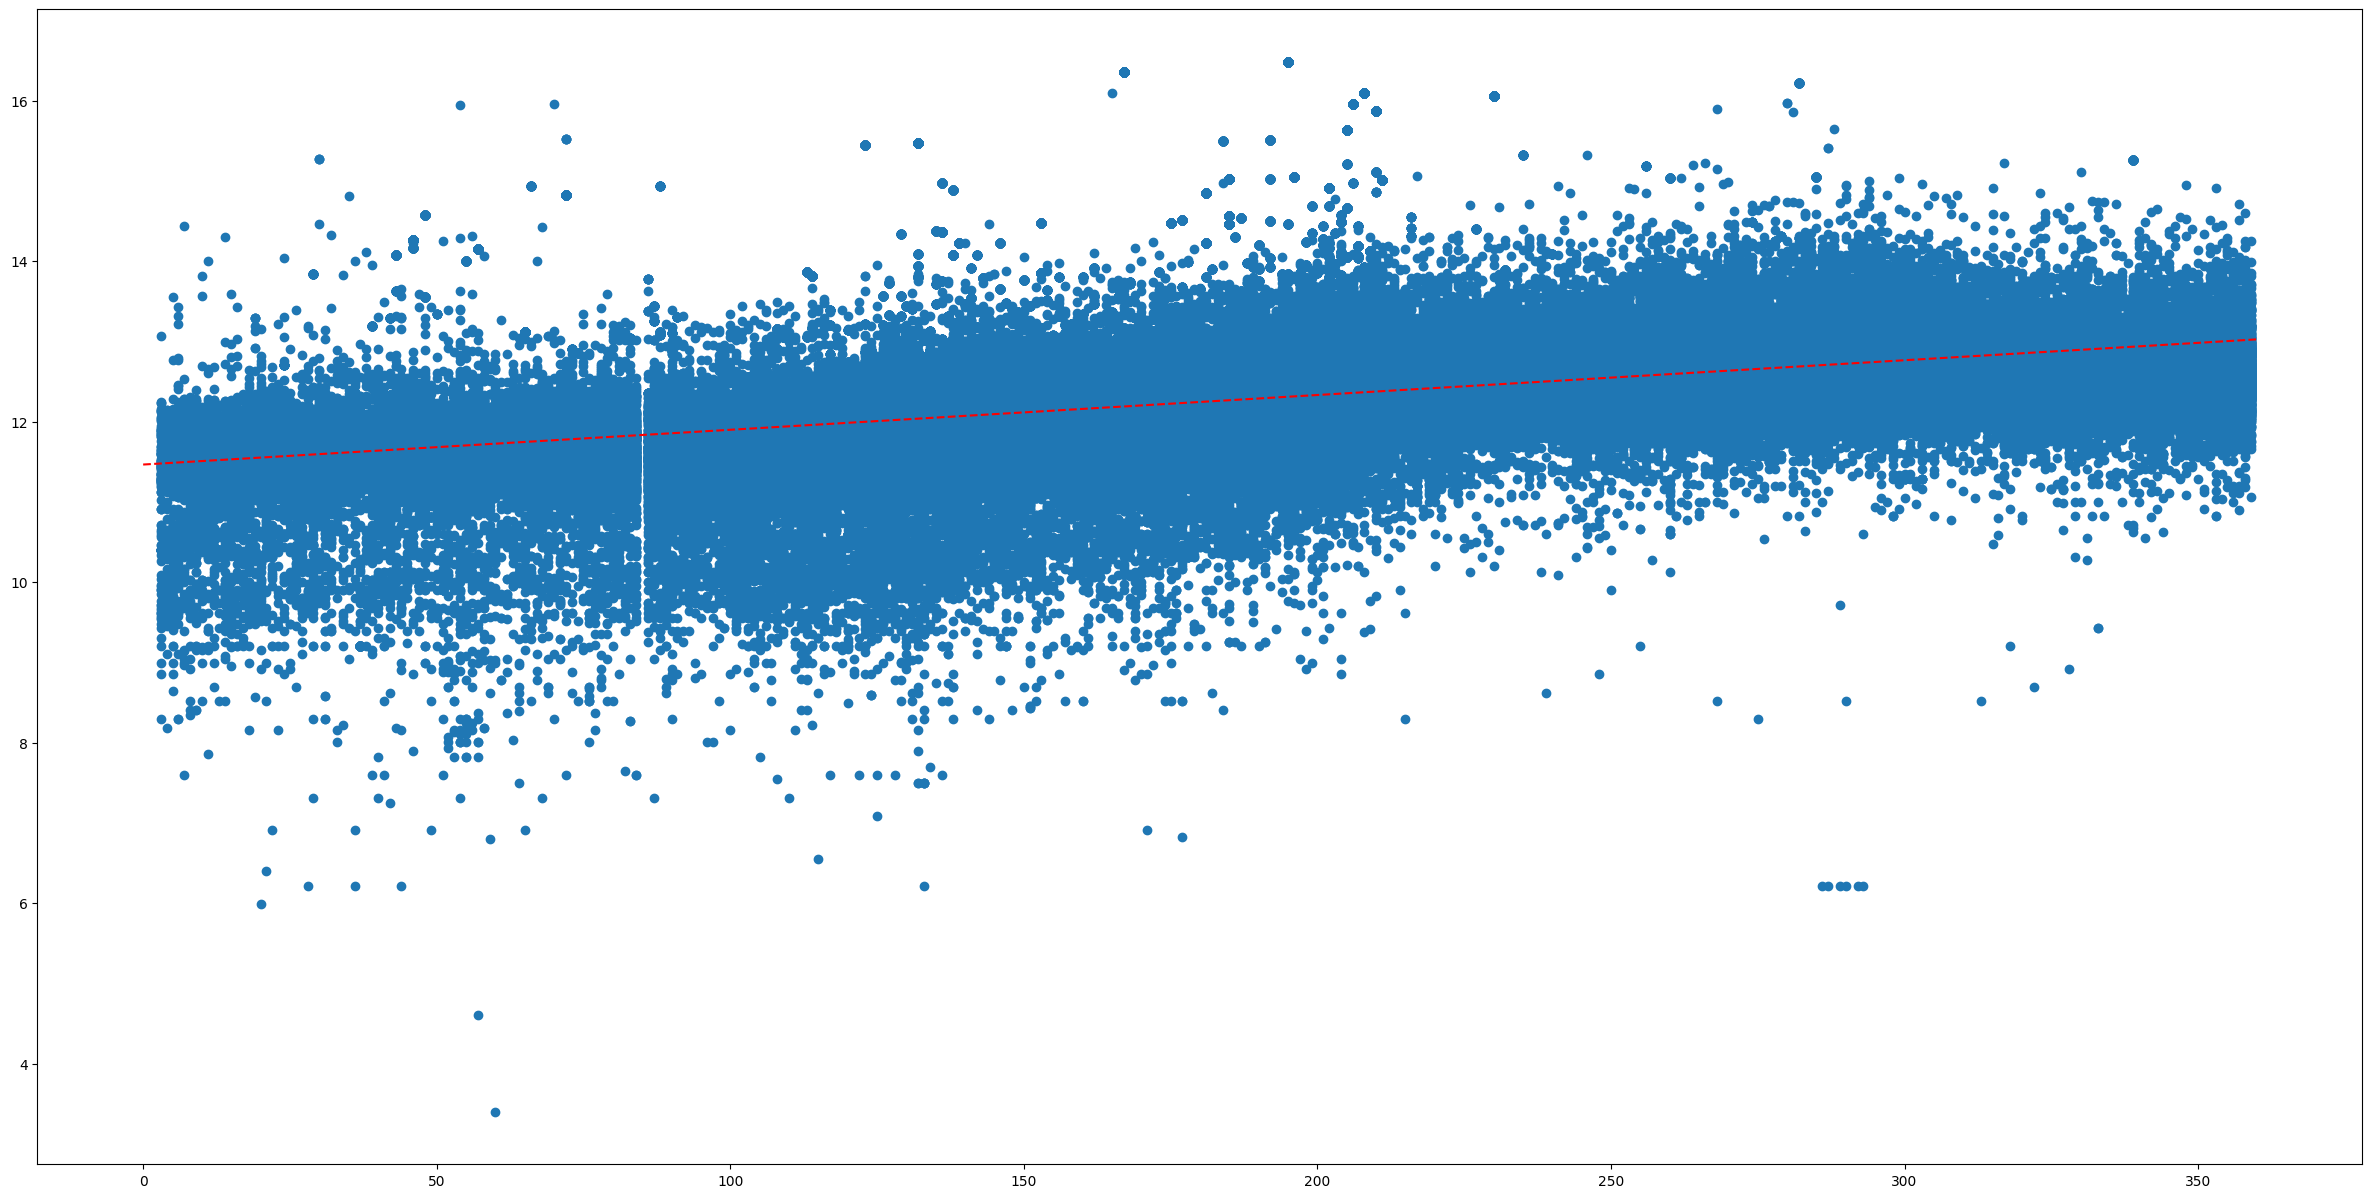

In [79]:
plt.figure(figsize=(30,15))
plt.scatter(train1.months_from_1983, train1.target)
plt.plot([0,360], [11.464922954023326,0.0043315907753953865*360 + 11.464922954023326], 'r--')

In [80]:
import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model